# Explicit Singularity programming tutorial

Demonstrates how to use basic CVBEM and the well class for analyzing problems involving multiple wells and no fracturs

In [1]:
# basic imports:

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import cmath as cm

If not done yet, download the pycvbem folder and all contents to the directory which will be your working directory for this and other tutorials.

In [2]:
# import core pycvbem functionality and explicit singularity classes
import pycvbem as cbm
from pycvbem.singularity.explicit import Well, ExpSingSuperposition


## The scenario:
For this tutorial, we will demonstrate the simulation of one quarter of a five-point well pattern. So there is an injection well at A:(0, 0) and an extraction well at C:(1, 1). B and D are at (1, 0) and (0, 1), respectively. At both B and D, we have the Dirichlet condition $P=0$. Along ABC we have the Neumann condition $S=1/4$ and along CDA we have $S=0$

Below, the wells and boundary conditions are defined.

In [3]:
# first, the wells:
# requred inputs to the Well class are zw: the location of the well as a complex number, 
# and qw_h: the ratio of well discharge to the height of the flow or the well, i.e. q/h
# optional inputs are as follows (in order of most likely to be relevant)
#     thetaBC: angle which the branch cut is rotated to from the location of the principal branch cut (along the -x axis)
#         So if the branch cut is to be along the -y axis, this should be pi/2, since the b.c. is rotate counterclockwise (ccw)
#     rw: well-bore radius, from which boundary points are to be excluded
#     lowerBC: value of the angle on the lower side of the b.c, the upper side is defind to be lowerBC + 2*pi
#     upExcl: bool argument specifying whether the branch cut is to be a closed-open (True, default) or open-closed interval (False)
#     ccw: bool, default True: whether the angle should be measured counter-clockwise (default) or clockwise from the b.c.

# source well at origin:
w1 = Well(0, 1) # use principal branch cut (b.c.) location

# sink well at (1, 1)
w2 = Well(1+1j, -1, thetaBC=np.pi) # rotate the b.c. location ccw by pi to the +x axis

# various well properties are available using dot notation: w1.zw, w2.thetaBC, w1.Omega(z), etc.

# because the solver treats all the wells and any other explicit singularity structures as a single unit,
# it is neccessary to build a superposition before supplying them to the solver:
exp = ExpSingSuperposition([w1, w2])

In [4]:
# Now, define the boundary conditions:
# the code below defines the arrays zb, P, and S so they are all the same length
# and there are no boundary points too close to the wells.
# nan values are entered where the boundary condition is not provided to signal
# that the value is unknown to the solver (the solver interprets the value zero as
# an actual datapoint)

# define how many points we want:
nb = 80

zb = []
P = []
S = []
# probably could do this with numpy
for k in range(nb//4): # along AB
    zb.append(w1.rw + k*(1-w1.rw)/(nb//4))
    S.append(1/4)
    P.append(np.nan) 
for k in range(nb//4): # along BC
    zb.append(1 + k*1j/(nb//4))
    if k == 0: # at B
        S.append(np.nan) # Dirichlet anchor
        P.append(0)
    else:
        S.append(1/4)
        P.append(np.nan)
for k in range(nb//4): # along CD
    zb.append(w2.zw-w2.rw - k*(1-w2.rw)/(nb//4))
    S.append(0)
    P.append(np.nan)
for k in range(nb//4): # along DA
    zb.append(1j - k*1j/(nb//4))
    if k == 0: # at D
        S.append(np.nan) # Dirichlet anchor
        P.append(0)
    else:
        S.append(0)
        P.append(np.nan)

# these statements confirm that zb, S, and P are the same length and zb has no repeated points:
# if any statement is false, the solver will not work
print(len(zb) == len(set(zb))) # a set cannot have repeat elements
print(len(S) == len(zb))
print(len(P) == len(zb))

# for convenience: make numpy
zb = np.array(zb)

# this scenario is also available as pycvbem.examples.quart5ptPattern(nb)

True
True
True


In [5]:
# We are now ready to use the solver which is part of the core of pycvbem
# the first return is a function for the complex potential at any z, the second is a list of complex nodal values
# The last return is a list of fracture parameters and is ignored here
OmegaTilde, nodals, _ = cbm.CVBEM(zb, P, S, expl_sing=exp)

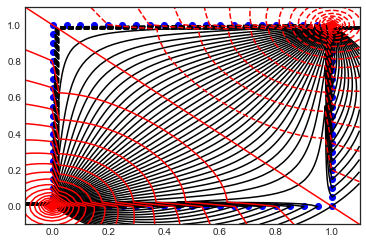

In [9]:
# now to plot the solution:
# use numpy to define the XY plane with meshgrid and vectorize OmegaTilde for computing the complex potential

x = np.linspace(-0.1, 1.1) # dont be on the boundary points, or the function will give complex domain errors
y = np.linspace(-0.1, 1.1)
X, Y = np.meshgrid(x, y)
Z = X + Y*1j

OT = np.vectorize(OmegaTilde)

Omega = OT(Z)

plt.figure()
plt.contour(X, Y, Omega.imag, levels=np.linspace(-1/8, 1/4, num=50), colors='k')
plt.contour(X, Y, Omega.real, levels=np.linspace(-1, 1, num=53), colors='r')
plt.scatter(zb.real, zb.imag, color='b');

# angle calculation is different or wrong?

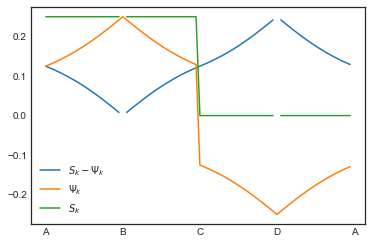

In [7]:
# also plot the boundary conditions we started with to demonstrate continuity:
plt.figure()
Psi = np.vectorize(exp.Psi)
plt.plot(S-Psi(zb), label='$S_k-\Psi_k$')
plt.plot(Psi(zb), label='$\Psi_k$')
plt.plot(S, label='$S_k$')
plt.legend()
plt.xticks(ticks=[0, 20, 40, 60, 80], labels=['A', 'B', 'C', 'D', 'A']);